In [ ]:
# imports
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import mat73
from IPython.display import display, Markdown

import pyaldata as pyal
import pylab
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from tools.curbd import curbd
import pylab
import importlib

from tools.dsp.preprocessing import preprocess
from tools.rnn_and_curbd.RNN_functions import *

np.random.seed(44)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [2]:
data_dir = "/data/bnd-data/raw/M044/M044_2024_12_04_09_30"
mat_file = "M044_2024_12_04_09_30_pyaldata.mat"
fname = os.path.join(data_dir, mat_file)

df = pyal.mat2dataframe(fname, shift_idx_fields=True)
mouse = mat_file.split('_')[0]

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


### Preprocess

In [3]:
df_ = preprocess(df, only_trials=True)
df_ = pyal.select_trials(df_, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off

# Separate columns of 'all_spikes' to M1 and Dls (dorsolateral striatum)
brain_areas = ["Dls_rates", "M1_rates"]
df_["M1_rates"] = [df_["all_rates"][i][:,300:] for i in range(len(df_))]
df_["Dls_rates"] = [df_["all_rates"][i][:,0:300] for i in range(len(df_))]

/home/zms24/.conda/envs/zofia_earthquake_env/earthquake-analysis/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)


### Variables

In [4]:
# perturbation time
perturbation_time = df_.idx_sol_on[0]
perturbation_time_seconds = perturbation_time * df_.bin_size[0]

# solenoid angles
sol_angles: list = df_.values_Sol_direction.unique()
sol_angles.sort()

# number of trials
num_trials = len(df_)
print(f"Number of trials: {num_trials}")

Number of trials: 493


### Concatinate all trials in time

In [5]:
concat_trials = pyal.concat_trials(df_, signal = "all_rates")

#### Plot concatinted activity

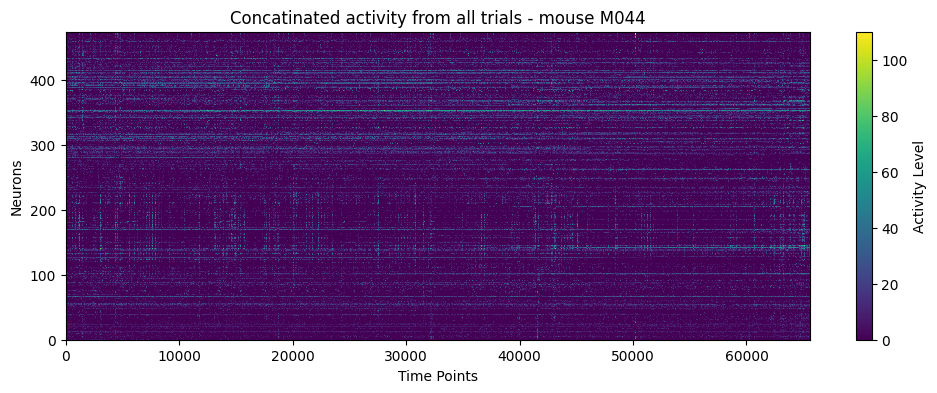

In [6]:
plot_neuron_activity(concat_trials, "Concatinated activity from all trials", mouse)

### Set up inputs for RNN training

In [7]:
dtFactor = 4
reset_points, trial_len = get_reset_points(df_, concat_trials, brain_areas, dtFactor)
activity = np.transpose(concat_trials)
regions = get_regions(df_, brain_areas)

print(reset_points)
print(f"Building {len(regions)} region RNN network")
print(f"Regions: {[region[0] for region in regions]}\n")

Trial length: 133
[0, 532, 1064, 1596, 2128, 2660, 3192, 3724, 4256, 4788, 5320, 5852, 6384, 6916, 7448, 7980, 8512, 9044, 9576, 10108, 10640, 11172, 11704, 12236, 12768, 13300, 13832, 14364, 14896, 15428, 15960, 16492, 17024, 17556, 18088, 18620, 19152, 19684, 20216, 20748, 21280, 21812, 22344, 22876, 23408, 23940, 24472, 25004, 25536, 26068, 26600, 27132, 27664, 28196, 28728, 29260, 29792, 30324, 30856, 31388, 31920, 32452, 32984, 33516, 34048, 34580, 35112, 35644, 36176, 36708, 37240, 37772, 38304, 38836, 39368, 39900, 40432, 40964, 41496, 42028, 42560, 43092, 43624, 44156, 44688, 45220, 45752, 46284, 46816, 47348, 47880, 48412, 48944, 49476, 50008, 50540, 51072, 51604, 52136, 52668, 53200, 53732, 54264, 54796, 55328, 55860, 56392, 56924, 57456, 57988, 58520, 59052, 59584, 60116, 60648, 61180, 61712, 62244, 62776, 63308, 63840, 64372, 64904, 65436, 65968, 66500, 67032, 67564, 68096, 68628, 69160, 69692, 70224, 70756, 71288, 71820, 72352, 72884, 73416, 73948, 74480, 75012, 75544, 760

### RNN training

trial=0 pVar=0.442076 chi2=213.025592
trial=1 pVar=0.464197 chi2=205.573666
trial=2 pVar=0.473254 chi2=202.133665
trial=3 pVar=0.477468 chi2=200.530493
trial=4 pVar=0.480047 chi2=199.549978
trial=5 pVar=0.481915 chi2=198.840774
trial=6 pVar=0.483353 chi2=198.295134
trial=7 pVar=0.484490 chi2=197.864207
trial=8 pVar=0.485405 chi2=197.517350
trial=9 pVar=0.486157 chi2=197.232930
trial=10 pVar=0.486784 chi2=196.995674
trial=11 pVar=0.487316 chi2=196.794852
trial=12 pVar=0.487772 chi2=196.622800
trial=13 pVar=0.488168 chi2=196.473876
trial=14 pVar=0.488514 chi2=196.343796
trial=15 pVar=0.488819 chi2=196.229229
trial=16 pVar=0.489090 chi2=196.127549
trial=17 pVar=0.489332 chi2=196.036662
trial=18 pVar=0.489551 chi2=195.954887
trial=19 pVar=0.489749 chi2=195.880867
trial=20 pVar=0.489971 chi2=195.801963


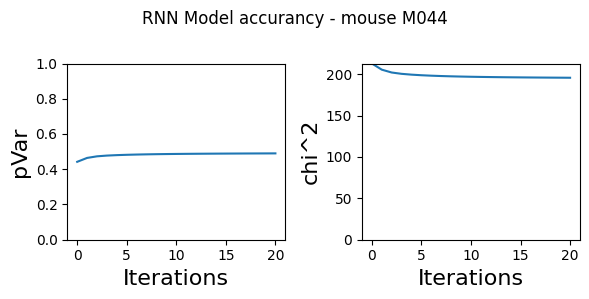

In [8]:
# RNN TRAINING
rnn_model, rnn_accurancy_figure = RNN(activity, reset_points, regions, df_, mouse, 
                                                        dtFactor = dtFactor, ampInWN= 0.01, tauRNN = 0.3, nRunTrain=20)

#### Plot activity generated by RNN

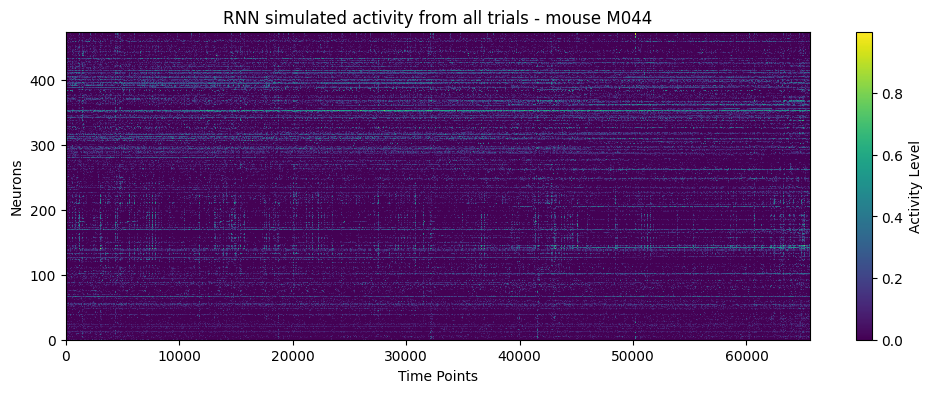

In [9]:
plot_neuron_activity(rnn_model['Adata'].T, "RNN simulated activity from all trials", mouse)

### RNN assesment with PCA and CCA

In [ ]:
# scores, variance_figure, PCA_figure = PCA_and_CCA(concat_trials, rnn_model, 
#                                                                   num_components = 100, trial_num = num_trials, mouse_num = mouse, 
#                                                                   printing=True)

KeyboardInterrupt: 

## PCA by region

In [23]:
fig1 = PCA_by_region(concat_trials, rnn_model, regions, num_trials, mouse)

NameError: name 'plot_PCs_by_region' is not defined

### CURBD

In [24]:
curbd_arr, curbd_labels = curbd.computeCURBD(rnn_model)
n_regions = curbd_arr.shape[0]

### Plotting currents

In [25]:
all_currents, all_currents_labels = format_for_plotting(curbd_arr, curbd_labels, n_regions, reset_points)

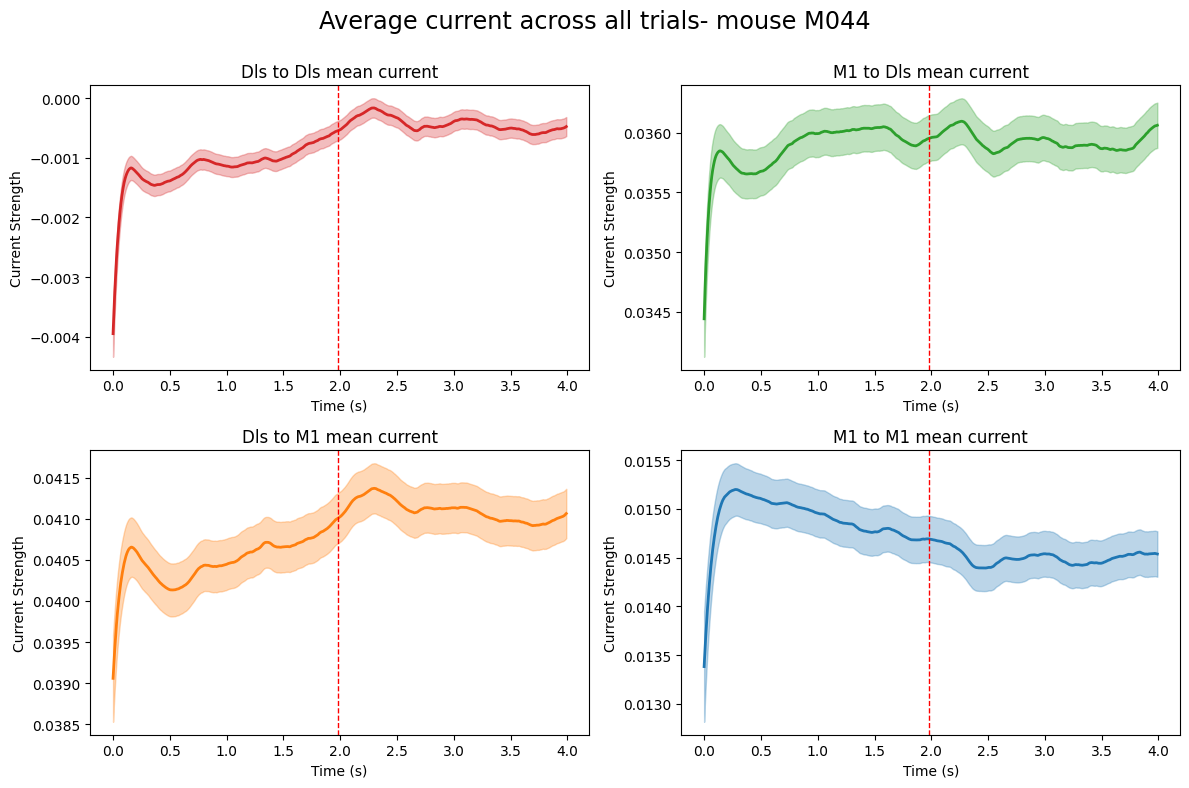

In [26]:
avg_currents_fig = plot_all_currents_seperate(all_currents, all_currents_labels, perturbation_time_seconds, df_.bin_size[0], dtFactor, mouse)